In [1]:
# Execute this code block to install dependencies when running on colab
try:
    import torch
except:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl torchvision

# Part 3: Variational Autoencoders (VAE)

For this part of the lab, you will implement a VAE. There is some code below which will help you run the learning procedure, however, you will need to complete the definition of the loss function. Start by implementing the encoder and decoder for the VAE. There is a diagram below illustrating what these architectures should look like.

Let's start by loading the Fashion-MNIST dataset again and transforming the data to a flattened tensor.

### Loading the Dataset

In [2]:
%matplotlib inline

import torchvision
import torchvision.transforms as transforms

batch_size = 256
image_dim = 784 #flattened

# dataset construction
transform = transforms.Compose([
    transforms.ToTensor(), # convert to tensor
    transforms.Lambda(lambda x: x.view(image_dim)) # flatten into vector
    ])

train_set = torchvision.datasets.FashionMNIST(
    root='./data/FashionMNIST'
    ,train=True
    ,download=True
    ,transform=transform
)

train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size
)

## Build a Simple Variational Autoencoder

<img src="http://comp6248.ecs.soton.ac.uk/labs/lab8/VAE_resized.png">

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm.autonotebook import tqdm
from itertools import chain

import numpy as np

class Encoder(nn.Module):
    '''
    simple encoder with a single hidden dense layer (ReLU activation)
    and linear projections to the diag-Gauss parameters
    '''
    # YOUR CODE HERE
    def __init__(self, input_dim, hidden_dim, latent_dim):
      super(Encoder, self).__init__()
      self.ec1 = nn.Linear(input_dim, hidden_dim)
      self.ec2 = nn.Linear(hidden_dim, latent_dim * 2)
      self.latent_dim=latent_dim
    
    def forward(self, x):
      out = self.ec1(x)
      out = torch.relu(out)
      out = self.ec2(out)
      return out[:, :self.latent_dim], out[:, self.latent_dim:]

class Decoder(nn.Module):
    '''
    simple decoder: single dense hidden layer (ReLU activation) followed by 
    output layer with a sigmoid to squish values
    '''
    # YOUR CODE HERE
    def __init__(self, latent_dim, hidden_dim, input_dim):
      super(Decoder, self).__init__()
      self.dc1 = nn.Linear(latent_dim, hidden_dim)
      self.dc2 = nn.Linear(hidden_dim, input_dim)

    def forward(self, x):
      out = self.dc1(x)
      out = torch.relu(out)
      out = self.dc2(out)
      out = torch.sigmoid(out)
      return out


## You may complete the code below to test your implementation, or alternately, rewrite your own.

#### Once you've trained the network plot some reconstructions side-by-side with the original images and reflect on how good the reconstructions are (or aren't!). Also try generating some random images by sampling the prior and feeding the vectors to the decoder.

In [4]:
import matplotlib.gridspec as gridspec    
import matplotlib.pyplot as plt
import os

# Sampling function (using the reparameterisation trick)
def sample(mu, log_sigma2):
    eps = torch.randn(mu.shape[0], mu.shape[1])
    return mu + torch.exp(log_sigma2 / 2) * eps


#parameters
batch_size = 256
embedding_dim = 2
enc_hidden_units = 512
dec_hidden_units = 512
nEpoch = 10

# construct the encoder, decoder and optimiser
enc = Encoder(image_dim, enc_hidden_units, embedding_dim)
dec = Decoder(embedding_dim, dec_hidden_units, image_dim)
optimizer = optim.Adam(chain(enc.parameters(), dec.parameters()), lr=1e-3)

# training loop
for epoch in range(nEpoch):
    losses = []
    trainloader = tqdm(train_loader)
  
    for i, data in enumerate(trainloader, 0):
        inputs, _ = data

        optimizer.zero_grad()

        mu, log_sigma2 = enc(inputs)
        z = sample(mu, log_sigma2)
        outputs = dec(z)

        # E[log P(X|z)] - as images are binary it makes most sense to use binary cross entropy
        # we need to be a little careful - by default torch averages over every observation 
        # (e.g. each  pixel in each image of each batch), whereas we want the average over entire
        # images instead
        recon = F.binary_cross_entropy(outputs, inputs, reduction='sum') / inputs.shape[0]

        kl = 0 
        # kl = D_KL(Q(z|X) || P(z|X)) - calculate in closed form
        # Compute the term kl which is then added to the total loss
        # YOUR CODE HERE
        kl = -0.5 * torch.sum(1 + log_sigma2 - mu.pow(2) - torch.exp(log_sigma2))
        
        loss = recon + kl / inputs.shape[0]
        loss.backward()
        optimizer.step()

        # keep track of the loss and update the stats
        losses.append(loss.item())
        trainloader.set_postfix(loss=np.mean(losses), epoch=epoch)

    ## Please display some of the generated images in the submitted Notebook
    # YOUR CODE HERE
    # batch = iter(train_loader).next()[0]
    # samples = batch[0:6]
    # fig = plt.figure(figsize=(8,6))
    # for i in range(0, 12, 2):
    #   ax1 = fig.add_subplot(3, 4, i+1)
    #   ax1.imshow(samples[i//2].reshape(28, 28), cmap=plt.get_cmap('gray'))
      
    #   mu, log_sigma2 = enc(samples)
    #   z = sample(mu, log_sigma2)
    #   outputs = dec(z)
    #   dec_images = outputs.cpu().data

    #   ax2 = fig.add_subplot(3, 4, i+2)
    #   ax2.imshow(dec_images[i//2].reshape(28, 28), cmap=plt.get_cmap('gray'))
    # plt.show()


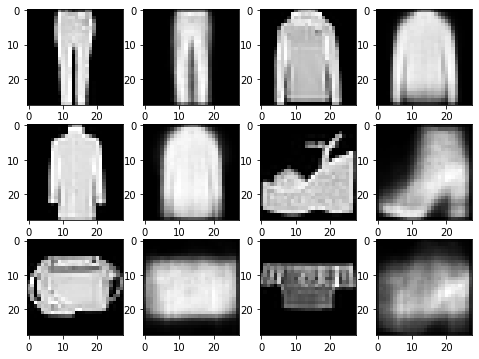

In [5]:
batch = iter(train_loader).next()[0]
samples = batch[np.random.choice(len(batch), 6)]

fig = plt.figure(figsize=(8,6))
for i in range(0, 12, 2):
  ax1 = fig.add_subplot(3, 4, i+1)
  ax1.imshow(samples[i//2].reshape(28, 28), cmap=plt.get_cmap('gray'))
  
  mu, log_sigma2 = enc(samples)
  z = sample(mu, log_sigma2)
  outputs = dec(z)
  dec_images = outputs.cpu().data

  ax2 = fig.add_subplot(3, 4, i+2)
  ax2.imshow(dec_images[i//2].reshape(28, 28), cmap=plt.get_cmap('gray'))
plt.show()


## Autoencoder

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AutoEncoder(nn.Module):
    '''
    simple encoder with no hidden dense layer
    '''
    def __init__(self, input_dim, hidden_dim):
        super(AutoEncoder, self).__init__()
        # YOUR CODE HERE
        self.fc = nn.Linear(input_dim, hidden_dim)

    def forward(self, x):
        # YOUR CODE HERE
        out = self.fc(x)
        out = torch.relu(out)
        return out

class AutoDecoder(nn.Module):
    '''
    simple decoder: single dense hidden layer followed by 
    output layer with a sigmoid to squish values
    '''
    def __init__(self, input_dim, output_dim):
        super(AutoDecoder, self).__init__()
        # YOUR CODE HERE
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        # YOUR CODE HERE
        out = self.fc(x)
        out = torch.sigmoid(out)
        return out

In [7]:
import matplotlib.gridspec as gridspec    
import os
import torch.optim as optim
import numpy as np

from tqdm.autonotebook import tqdm
from itertools import chain

image_dim = 784  # [flattened]
enc_dim = 2
nEpoch = 10

# construct the encoder, decoder and optimiser
auto_enc_latent = AutoEncoder(image_dim, enc_dim)
auto_dec_latent = AutoDecoder(enc_dim, image_dim)
optimizer = optim.Adam(chain(auto_enc_latent.parameters(), auto_dec_latent.parameters()), lr=1e-3)

# training loop
for epoch in range(nEpoch):
    losses = []
    trainloader = tqdm(train_loader)

    for i, data in enumerate(trainloader, 0):
        inputs, _ = data
        optimizer.zero_grad()

        z = auto_enc_latent(inputs)
        outputs = auto_dec_latent(z)

        loss = F.binary_cross_entropy(outputs, inputs, reduction='sum') / inputs.shape[0]
        loss.backward()
        optimizer.step()

        # keep track of the loss and update the stats
        losses.append(loss.item())
        trainloader.set_postfix(loss=np.mean(losses), epoch=epoch)


##Generate Image

grid_x: tensor([-3.6468, -3.2615, -3.1199, -1.8390, -1.6796, -0.9357, -0.9261, -0.8466,
        -0.4676,  0.6179,  1.2234,  1.4051,  1.5369,  1.5711,  2.2226,  2.4144,
         2.4694,  2.5541,  3.2441,  3.7117,  3.9474])
grid_y: tensor([ 3.9489,  3.1397,  3.0377,  2.3212,  2.2862,  2.2444,  1.8625,  1.1702,
         0.9048,  0.3281,  0.1406, -0.0639, -0.1654, -0.6623, -0.7199, -1.1607,
        -1.5440, -1.7724, -3.3073, -3.7039, -3.8594])



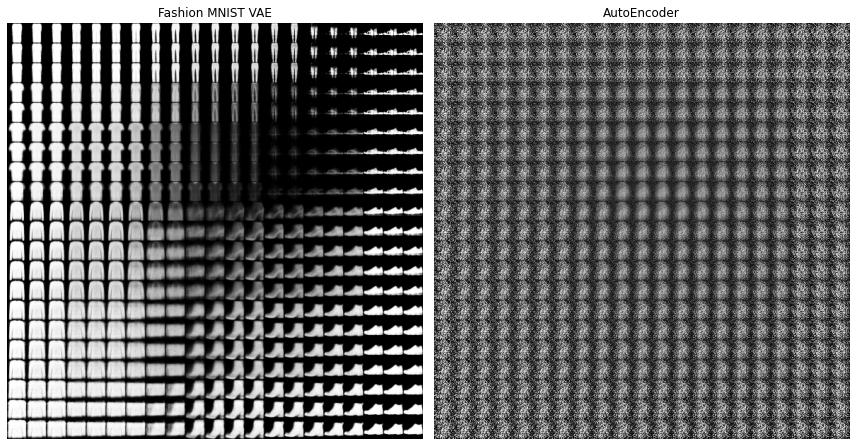

In [8]:
# Display a 2D manifold of the digits
n = 21  # figure with 21x21 digits
digit_size = 28

figure = np.zeros((digit_size * n, digit_size * n))
figure_auto = np.zeros((digit_size * n, digit_size * n))

# We will sample n points within [-4, 4] standard deviations
grid_x = 8*torch.rand(n)-4
grid_y = 8*torch.rand(n)-4
grid_x = torch.sort(grid_x).values
grid_y = torch.sort(grid_y, descending=True).values

print('grid_x:', grid_x)
print('grid_y:', grid_y)
print()


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

for i, xi in enumerate(grid_x):
    for j, yi in enumerate(grid_y):
        z_sample = torch.tensor([[xi, yi]]).float()
        
        x_decoded = dec(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit.cpu().data

        x_decoded = auto_dec_latent(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure_auto[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit.cpu().data

        # if i%6 == 0 and j%4 == 0:
          # plt.annotate(str(int(xi.item()))+','+str(int(yi.item())), (i*digit_size, j*digit_size), color='r')

ax1.imshow(figure, cmap=plt.get_cmap('gray'))
ax1.set_title('Fashion MNIST VAE')
ax1.axis('off')

ax2.imshow(figure_auto, cmap=plt.get_cmap('gray'))
ax2.set_title('AutoEncoder')
# ax.set_yticklabels(np.arange(int(max(grid_y) + 1), int(min(grid_y)) - 1, -1))
# ax.set_xticklabels(np.arange(int(min(grid_x) - 1), int(max(grid_x)) + 1))
ax2.axis('off')

plt.tight_layout()
plt.show()


In [9]:
figure.shape


(588, 588)

## Load MNIST

In [10]:
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

# flatten 28*28 images to a 784 vector for each image
transform = transforms.Compose([
    transforms.ToTensor(),  # convert to tensor
    transforms.Lambda(lambda x: x.view(-1))  # flatten into vector
])
# without this agent, downloading will fail!
# https://github.com/pytorch/vision/issues/1938#issuecomment-594503267
# https://github.com/pytorch/vision/issues/1938#issuecomment-594623431
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

trainset_mnist = MNIST(".", train=True, download=True, transform=transform)


--2021-03-31 20:33:56--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2021-03-31 20:33:57--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz.8’

MNIST.tar.gz.8          [      <=>           ]  33.20M  5.03MB/s    in 18s     

2021-03-31 20:34:16 (1.80 MB/s) - ‘MNIST.tar.gz.8’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw

In [11]:

#parameters
batch_size =128

# create data loaders
train_loader_mnist = DataLoader(trainset_mnist, batch_size=batch_size)


import matplotlib.gridspec as gridspec    
import matplotlib.pyplot as plt
import os

# Sampling function (using the reparameterisation trick)
def sample(mu, log_sigma2):
    eps = torch.randn(mu.shape[0], mu.shape[1])
    return mu + torch.exp(log_sigma2 / 2) * eps


embedding_dim = 2
enc_hidden_units = 512
dec_hidden_units = 512
nEpoch = 10

# construct the encoder, decoder and optimiser
enc_mnist = Encoder(image_dim, enc_hidden_units, embedding_dim)
dec_mnist  = Decoder(embedding_dim, dec_hidden_units, image_dim)
optimizer = optim.Adam(chain(enc_mnist.parameters(), dec_mnist.parameters()), lr=1e-3)

# training loop
for epoch in range(nEpoch):
    losses = []
    train_loader_tqdm_mnist = tqdm(train_loader_mnist)

    for i, data in enumerate(train_loader_tqdm_mnist, 0):
        inputs, _ = data

        optimizer.zero_grad()

        mu, log_sigma2 = enc_mnist(inputs)
        z = sample(mu, log_sigma2)
        outputs = dec_mnist(z)

        # E[log P(X|z)] - as images are binary it makes most sense to use binary cross entropy
        # we need to be a little careful - by default torch averages over every observation 
        # (e.g. each  pixel in each image of each batch), whereas we want the average over entire
        # images instead
        recon = F.binary_cross_entropy(outputs, inputs, reduction='sum') / inputs.shape[0]

        kl = 0 
        # kl = D_KL(Q(z|X) || P(z|X)) - calculate in closed form
        # Compute the term kl which is then added to the total loss
        # YOUR CODE HERE
        kl = -0.5 * torch.sum(1 + log_sigma2 - mu.pow(2) - torch.exp(log_sigma2))
        
        loss = recon + kl / inputs.shape[0]
        loss.backward()
        optimizer.step()

        # keep track of the loss and update the stats
        losses.append(loss.item())
        train_loader_tqdm_mnist.set_postfix(loss=np.mean(losses), epoch=epoch)


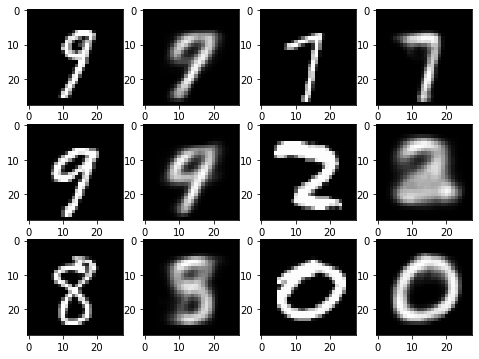

In [12]:
batch = iter(train_loader_mnist).next()[0]
samples = batch[np.random.choice(len(batch), 6)]

fig = plt.figure(figsize=(8,6))
for i in range(0, 12, 2):
  ax1 = fig.add_subplot(3, 4, i+1)
  ax1.imshow(samples[i//2].reshape(28, 28), cmap=plt.get_cmap('gray'))
  
  mu, log_sigma2 = enc_mnist(samples)
  z = sample(mu, log_sigma2)
  outputs = dec_mnist(z)
  dec_images = outputs.cpu().data

  ax2 = fig.add_subplot(3, 4, i+2)
  ax2.imshow(dec_images[i//2].reshape(28, 28), cmap=plt.get_cmap('gray'))
plt.show()


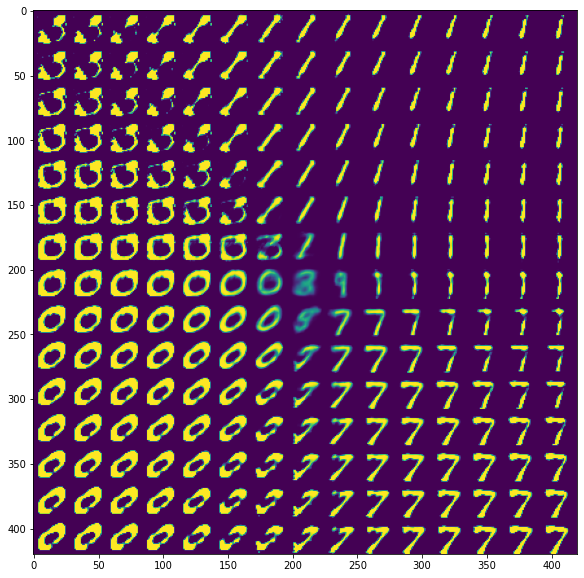

In [13]:
# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = torch.tensor([[xi, yi]]).float()
        
        x_decoded = dec_mnist(z_sample)
        
        digit = x_decoded[0].reshape(digit_size, digit_size)
        
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit.cpu().data

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()
